# Bankruptcy in the Netherlands

## Course: Programming with data (INFOB2PWD)

### Students: Annette Holst, Georg Vasiliv, Robin Papenhuijzen and Rina van Woerden

This data set contains information on the number of bankruptcy orders issued by Dutch Courts. The data is categorized based on the type of bankruptcy. It can be natural persons with or without sole proprietorship, enterprises, institutions and geographical regions.
The time span of this dataset is from January 2009 till February 2025. The latest figures are subject to revision and the last two months are provisional.

The time span of this dataset is from January 2009 till February 2025. The latest figures are subject to revision and the last two months are provisional. The significance level is  $a=0.05$. 

First, an overview of the data set will be given and the data set will be prepared for the analysis. Then the following research' questions will be explored:
* How have bankruptcy rates changed over time?
* How do bankruptcy trends differ across different geographical regions?
* How do bankruptcy trends differ between the Randstad and the suburbs?
* How did bankruptcy trends differ for businesses with and without sole proprietorships before and after COVID-19?


### NOG DOEN !!! : Longer pieces of code, especially when not directly meaningful for the narrative (for example details of the data pre-processing when loading the data from the CSV files), are stored in separate .py modules and imported to the notebook

In [69]:
# Pre-install libraries new libraries 
# pip install matplotlib
# pip install plotnine
# pip install statsmodels
# pip install seaborn
# pip install plotly.express
# pip install geopandas

In [70]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import requests
import matplotlib.image as mpimg
from plotnine import *
from statsmodels.formula.api import ols 
import statsmodels.api as sm
import pandas as pd
import plotly.express as px
import json
from urllib.request import Request, urlopen
import geopandas as gpd
import warnings

In [71]:
# Transforming the csv-file to a data frame
df = pd.read_csv("82522ENG_UntypedDataSet_20032025_155613.csv", sep = ";")
# Overview of the data set
df.head()

ID TypeOfBankruptcy Regions   Periods  PronouncedBankruptcies_1
0   0          A047596  NL00    2009MM01                       563
1   1          A047596  NL00    2009MM02                       601
2   2          A047596  NL00    2009MM03                       768
3   3          A047596  NL00    2009KW01                      1932
4   4          A047596  NL00    2009MM04                       717

**Structure of the dataset**

The above table gives an overview of the dataset used in this research. Each row represents the number of bankruptcies declared in a specific period and region in the Netherlands. The 'TypeOfBankruptcy' column contains codes such as 'A047596', which refer to different categories of bankruptcies, for example, total bankruptcies or those involving only sole proprietorships. The 'Regions' column shows region codes like 'NL00', while the 'Periods' column indicates specific months or quarters (e.g.,'2009MM01' for January 2009 or '2009KW01' for the first quarter of 2009). Finally, the 'PronouncedBankruptcies_1' column provides the actual number of declared bankruptcies per observation.

This table illustrates the structure of the data and highlights both regional and temporal trends in bankruptcies across the Netherlands

In [73]:
# Shows the size of the data set and the data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49320 entries, 0 to 49319
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        49320 non-null  int64 
 1   TypeOfBankruptcy          49320 non-null  object
 2   Regions                   49320 non-null  object
 3   Periods                   49320 non-null  object
 4   PronouncedBankruptcies_1  49320 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 1.9+ MB
None


In [74]:
# Statistics of the data set
print(df.describe())

                 ID  PronouncedBankruptcies_1
count  49320.000000              49320.000000
mean   24659.500000                 51.365977
std    14237.601975                246.609041
min        0.000000                  0.000000
25%    12329.750000                  2.000000
50%    24659.500000                  8.000000
75%    36989.250000                 27.000000
max    49319.000000               9431.000000


**Descriptive Statistics analysis**: 
The number of bankruptcies in the dataset varies, ranging from a **minimum of 0** to a **maximum of 9,431**. The **average number** of bankruptcies is approximately **51**, while the **median** islower at **8**, indicating a **right-skewed distribution**. The **standard deviation** of **246.6** further confirms that there is substantial variation across provinces and time periods. These descriptive statistics highlight the need to explore regional and temporal patterns more closely, as a few regions likely experience disproportionately high levels of bankruptcies.

In [76]:
# Count unique values of tye of bankruptcy
type_bankruptcy = df.value_counts('TypeOfBankruptcy')
print(type_bankruptcy)

# Count unique values of regions (output not shown here, because there are many reasons)
# regions = df.value_counts('Regions')
# print(regions)

TypeOfBankruptcy
A028820    16440
A047596    16440
A047597    16440
Name: count, dtype: int64


As shown, there are three types of bankruptcies: A028820, A047596 and A047597    
Each type of bankruptcy has 16.440 rows.

As deriven from the meta-data, the codes mean the following:
* *A028820*: Nat. person with sole proprietorship
    * A legal form without legal personality, where one natural person owns the business. The owner is entirely liable for all business and capital matters. There is no distinction between business assets and personal assets.
* *A047596* stands for Total entities with/without legal pers.
    * Total entities with and without legal personality and sole proprietors
* *A047597* stands for Companies and institutions
    * Partnerships without legal personality and legal entities
 
To make the data set more clear, we will rename these codes to:
* A028820: only_sole_prop
* A047596: total
* A047597: without_sole_prop

In [78]:
# Renaming types of bankruptcies
df = df.replace('A028820','only_sole_prop')
df = df.replace('A047596','total')
df = df.replace('A047597','without_sole_prop') 

# Check if succeeded
type_bankruptcy = df.value_counts('TypeOfBankruptcy')
print(type_bankruptcy)

TypeOfBankruptcy
only_sole_prop       16440
total                16440
without_sole_prop    16440
Name: count, dtype: int64


The table above shows the different types of bankruptcies included in the dataset. Since these are initially represented by coded values (e.g., A028820), they have been converted into more descriptive labels that reflect the actual bankruptcy categories.

In [80]:
i = 20
t = 0
# List of provinces
list = ['Groningen', 'Fryslan', 'Drenthe', 'Overijssel', 'Flevoland', 'Gelderland', 'Utrecht', 'Noord-Holland', 'Zuid-Holland', 'Zeeland', 'Noord-Brabant', 'Limburg']
# For-loop to replace provinces indexes with names
for i in range(20,32):
    df = df.replace(f'PV{i}  ',f'{list[t]}')
    t = t + 1

# Check if it worked
# regions = df.value_counts('Regions')
# print(regions)

In [81]:
# Missing values => meta-data? (annette)

In [82]:
#Replacing provinces' names
df['Regions'] = df['Regions'].str.strip()
province_map = {
    'PV20': 'Groningen',
    'PV21': 'Fryslan',
    'PV22': 'Drenthe',
    'PV23': 'Overijssel',
    'PV24': 'Flevoland',
    'PV25': 'Gelderland',
    'PV26': 'Utrecht',
    'PV27': 'Noord-Holland',
    'PV28': 'Zuid-Holland',
    'PV29': 'Zeeland',
    'PV30': 'Noord-Brabant',
    'PV31': 'Limburg'
}
df['Regions'] = df['Regions'].replace(province_map)
df_total = df[df['TypeOfBankruptcy'] == 'total']


## Research 1: How do bankruptcy trends differ across different geographical regions?
A recent article from Algemeen Dagblad (2025) reported that the provinces of North Holland, South Holland, and North Brabant exeperienced the highest number of bankruptcies in the Netherlands. The article notes that the peak occured in 2013, during the height of the Eurocrisis. In addition, bankruptcies increased sharply between 2023 and 2024, with over 30% more cases reported in 2024 compared to the previous year. These developments highlights the importance of analyzing regional bankruptcy trends over time. This research focuses, therefore, on the period from 2009 to 2024 to examine whether there are significant differences in bankruptcy rates across Dutch provences. 

In [84]:
#Method: (Choropleth maps) Visualizing the number of bankruptcies per aregion, regions with higher bankruptcy rates can be displayed larger.

In [85]:
#Imports
import pandas as pd
import plotly.express as px #for the 
import json
from urllib.request import Request, urlopen

#load bankruptcy dataset
# df = pd.read_csv("/Users/annetteholst/Downloads/82522ENG_UntypedDataSet_21032025_093842.csv", sep=";")

#replace type codes with readable labels
df['TypeOfBankruptcy'] = df['TypeOfBankruptcy'].replace({
    'A028820': 'only_sole_prop',
    'A047596': 'total',
    'A047597': 'without_sole_prop'
})
df['Regions'] = df['Regions'].str.strip()

#filter only 'total' bankruptcies because this is total entities with and without legal personality and sole proprietors
df_total = df[df['TypeOfBankruptcy'] == 'total']

#filter to specific years 
researched_period = ["2009JJ00","2010JJ00", "2011JJ00","2012JJ00","2013JJ00", "2014JJ00", "2015JJ00","2016JJ00","2017JJ00","2018JJ00", "2019JJ00", "2020JJ00", "2021JJ00", "2022JJ00", "2023JJ00", "2024JJ00"]
df_total = df_total[df_total['Periods'].isin(researched_period)]

#replace region codes with province names before grouping
province_map = {
    'PV20': 'Groningen', 'PV21': 'Friesland (Fryslân)', 'PV22': 'Drenthe', 'PV23': 'Overijssel',
    'PV24': 'Flevoland', 'PV25': 'Gelderland', 'PV26': 'Utrecht', 'PV27': 'Noord-Holland',
    'PV28': 'Zuid-Holland', 'PV29': 'Zeeland', 'PV30': 'Noord-Brabant', 'PV31': 'Limburg'
}
df_total['Regions'] = df_total['Regions'].replace(province_map)

#extract year manually from the researched_period codes
df_total['Year'] = df_total['Periods'].str.extract(r'^(\d{4})').astype(int)

#group by province and year to see evolution over time
df_by_region_year = df_total.groupby(['Regions', 'Year'])['PronouncedBankruptcies_1'].sum().reset_index()
df_by_region_year.columns = ['province', 'year', 'bankruptcies']

#Load GeoJSON from webuildinternet.com
geo_url = 'https://www.webuildinternet.com/articles/2015-07-19-geojson-data-of-the-netherlands/provinces.geojson'

def read_geojson(url):
    #custom request to access the GeoJSON URL and avoid a Forbidden (403) error
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    with urlopen(req) as response:
        jdata = json.loads(response.read().decode())
    return jdata

jdata = read_geojson(geo_url)

#source: https://stackoverflow.com/questions/67475470/while-reading-json-data-from-url-using-python-gives-error-urllib-error-httperro

#animated choropleth map with years and colours using plotly
fig = px.choropleth(
    df_by_region_year,
    geojson=jdata,
    locations='province',
    featureidkey='properties.name',
    color='bankruptcies',
    hover_name='province',
    animation_frame='year',
    range_color=(0, 1600), #range to see better color contrast for interpretation
    color_continuous_scale='Oranges',
    projection='mercator'
)

fig.update_geos(
    visible=True,
    resolution=110,
    showcountries=True,
    showland=True,
    fitbounds="locations",
    center={"lat": 52.1, "lon": 5.2}
    

)
fig.update_layout(
    title='Bankruptcies by Province in the Netherlands (2009–2024)',
    margin={"r":0,"t":30,"l":0,"b":0}
)
fig.show()

#Source: https://plotly.com/python/map-configuration/ 
#Source: https://stackoverflow.com/questions/63368201/plotly-choropleth-according-to-a-number-state

The interactive choropleth map provides a visualization of how bankruptcies in the Netherlands have changed over time and across provinces. A consistent trend is visible throughout the observed period, where the provinces of North Holland, South Holland, and North Brabant experienced the highest number of bankruptcies (the darker provinces in the choropleth map). This concentration is possible linked to the fact that these regions are economic centers with compact populations and high levels of business activity, making them more vulnerable to increases in bankruptcies. This is supported by Karthaus (2025), who notes that most Dutch companies are located in these three provinces. The distribution of businesses across the country, which can be seen in the image below, further confirms that the highest concentration of companies is found in North Holland, South Holland, and North Brabant, increasing the likelihood of higher bankruptcy rates in these areas. As was the case during the Eurozone crisis, these economically active regions appear to be more vulnerable to national or global financial disruptions.

In [144]:
%%html
<iframe width="100%" height="500" 
source="https://my.visme.co/_embed/01nqwex0-kaart-nederland-met-aantallen-bedrijven?responsive=1" 
frameborder="0" allowfullscreen></iframe>

#source: https://stackoverflow.com/questions/36564945/iframe-video-100-width/36565178

In [88]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

In [89]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# ANOVA: Do provinces differ significantly in total bankruptcies?
model = ols('bankruptcies ~ C(province)', data=df_by_region_year).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("ANOVA result:")
print(anova_table)

#source: https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html

ANOVA result:
                   sum_sq     df          F         PR(>F)
C(province)  9.203166e+08   59.0  67.484249  6.942450e-288
Residual     2.080297e+08  900.0        NaN            NaN


The ANOVA result above shows that there is statistical evidence that bankruptcy rates differ significantly between provinces in the Netherlands across the years **2009–2024**.  
The p-value is below the significant level of 0.05, which confirms that the observed differences are **not due to chance**.

This supports what the choropleth map showed visually. Provinces like **North Holland**, **South Holland**, and **North Brabant** consistently report higher bankruptcy volumes than others.


## Research 2: How have bankruptcy rates changed over time in the Netherlands from 2009 until 2024? 

##### In order to investigate how the total bankruptcies have changed over time I combine the years (x) with the total bankruptcies (y).  I use pandas as pd and matplotlib that where explained in the excericis of the lectures to get a clear outcome of the results

In [136]:


# the first step is to modify the data frame, so that we only have the total bankruptcies for each year. 
# use NL01 , since it only accounts for 'total bankruptcies for Nederland.

modified_df = df[df["Periods"].astype(str).str.contains("JJ", na=False) & df["Regions"].astype(str).str.contains("NL01", na=False) & df["TypeOfBankruptcy"].astype(str).str.contains("total", na=False)]
print(modified_df) 



      ID TypeOfBankruptcy Regions   Periods  PronouncedBankruptcies_1
290  290            total    NL01  2009JJ00                      7987
307  307            total    NL01  2010JJ00                      7146
324  324            total    NL01  2011JJ00                      6854
341  341            total    NL01  2012JJ00                      8335
358  358            total    NL01  2013JJ00                      9394
375  375            total    NL01  2014JJ00                      7580
392  392            total    NL01  2015JJ00                      5987
409  409            total    NL01  2016JJ00                      4988
426  426            total    NL01  2017JJ00                      3849
443  443            total    NL01  2018JJ00                      3616
460  460            total    NL01  2019JJ00                      3774
477  477            total    NL01  2020JJ00                      3162
494  494            total    NL01  2021JJ00                      1799
511  511            

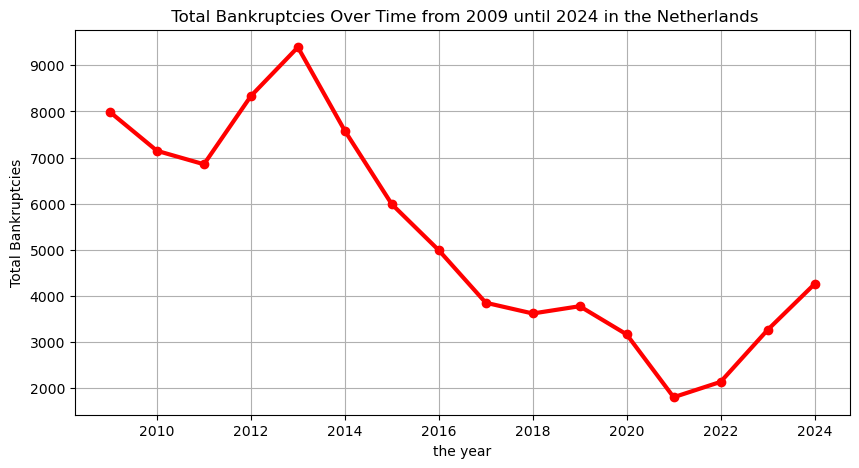

In [93]:
# Now we can make the x(time periods and y total bankruptcies
x = modified_df["Periods"]
y = modified_df["PronouncedBankruptcies_1"]

# from there we change the periods to numeric values for better plotting so 2009jj00 becomes 2009
x = x.str[:4].astype(int) 

# Plot the data, used matplotlib to modify the plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, marker="o", linestyle="-", color="r", linewidth=3)

# now change the names
plt.xlabel("the year")
plt.ylabel("Total Bankruptcies")
plt.title(" Total Bankruptcies Over Time from 2009 until 2024 in the Netherlands")
plt.grid(True) # see each year with the dot

# Show plot
plt.show()


##### The plot shows an interesting insight, namely that the aftermath of the 2008 crisis is visible from 2009 until 2013, with at least 7000 bankruptcies recorded each year. However after 2013 we observe a downward trend until 2021. From that point onward, bankruptcies begin to rise again, possible the aftermath of the Covid crisis? To find out, further research has been done in research 3. 

Research 3:

## Research 4: Bankruptcy trends before and after COVID-19: sole proprietorships vs. other businesses

Last week a news article was published about the economical impact of COVID-19 on the Netherlands (Schallenberg, 2025). The expectation at the beginning of COVID-19 was that businesses with little to no revenue would go bankrupt, but in reality fewer and fewer businesses went bankrupt. According to the article it was only since 2024 that bankruptcies exceeded pre-COVID levels (see the picture below). The first (registered) case of COVID-19 in the Netherlands was in the beginning in 2020. 

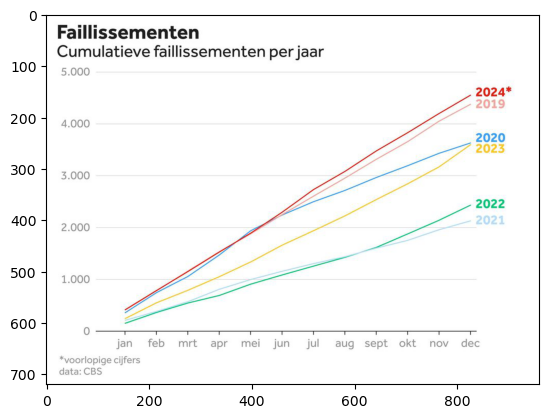

In [97]:
# Retrieve image from NOS-article
image = requests.get('https://cdn.nos.nl/image/2025/03/16/1203490/960x720a.jpg')

# Download and save the image in the␣ same location as the .ipynb file
with open('nos.jpg', 'wb') as image_file: 
    image_file.write(image.content)

# Print the image as a plot
image = mpimg.imread('nos.jpg')
plt.imshow(image)
plt.show()


It would be interesting to see if this same bankruptcy trend differs accros different types of proprietorship: companies only with and without sole proprietorship. This leads to the following research' question: How did bankruptcy trends differ for businesses with and without sole proprietorships before and after COVID-19?

First, an overview of annual bankruptcy trends will be analyzed, focusing on the same period Schallenberg (2025) used for her conclusions. However, since COVID-19 emerged in 2019, we will also include data from 2018, so the trends before COVID-19 had an impact will be studied. After establishing this general overview, we will conduct a more statistical approach of bankruptcy trends, comparing the periods before and after the pandemic.

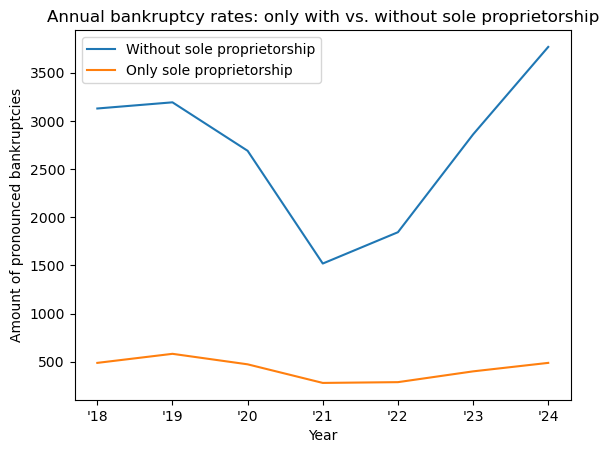

In [99]:
# List of years within studied timeframe
researched_period = ["2018JJ00", "2019JJ00", "2020JJ00", "2021JJ00", "2022JJ00", "2023JJ00", "2024JJ00"]

# Create a subset of the data without sole prorietory every year in the Netherlands
df_without_sol = df[df["Periods"].isin(researched_period) & df["Regions"].astype(str).str.contains("NL01", na=False) & df["TypeOfBankruptcy"].astype(str).str.contains("without_sole_prop", na=False)]

# Create a subset of the data with only sole prorietory every year in the Netherlands
df_only_sol = df[df["Periods"].isin(researched_period) & df["Regions"].astype(str).str.contains("NL01", na=False) & df["TypeOfBankruptcy"].astype(str).str.contains("only_sole_prop", na=False)]

# Function to replace period names with shortened names with a more readable format
def dataframe(z):
    i = 0 
    year = 2018
    count = 18
    for i in range(0,7):
            z = z.replace(f"{year}JJ00" ,f"'{count}")
            year = year + 1
            count = count + 1
    return z

# Applying the functions on the subsets
df_without_sol = dataframe(df_without_sol)
df_only_sol = dataframe(df_only_sol)

# Combining the dataframes into one plot
x = df_only_sol["Periods"]
y1 = df_without_sol["PronouncedBankruptcies_1"]
y2 = df_only_sol["PronouncedBankruptcies_1"]
plt.plot(x, y1, label='Without sole proprietorship')
plt.plot(x, y2, label='Only sole proprietorship')
plt.legend()
plt.title('Annual bankruptcy rates: only with vs. without sole proprietorship')
plt.xlabel('Year')
plt.ylabel('Amount of pronounced bankruptcies')
plt.show()


As shown in the graph above, from 2018 till 2019 there seems to be an increasing trend in the amount of pronounced bankruptcies for both businesses with and without sole proprietorships. However, there is a clear difference in the number of pronounced bankruptcies between the two groups. Businesses without sole proprietorships experience fluctuations between 1.500 and 3.500 bankruptcies per year during this period, whereas sole proprietorships consistently remain around 500 bankruptcies annually. The trend of declining business bankruptcies during COVID-19, as noted by Schallenberg (2025), appears to be accurate. However, this downward trend had already begun in 2019, even before the first COVID-19 case was diagnosed in the Netherlands. Starting in 2021, the number of pronounced bankruptcies began to rise. From 2022 onward, there was a notable surge in bankruptcies among businesses without sole proprietorships. For sole proprietorships there seems to be a relative steeper increase in bankruptcies from 2022 onward. 

To determine whether the difference between sole proprietorships and businesses without sole proprietorships before and after COVID-19 is significant, we will conduct a two-way ANOVA (Variance analysis). The pre-COVID-19 period will be defined as 2018 through 2019, while the post-COVID-19 period will begin in 2023.

In [101]:
# List of before and after Covid-years
years = ["2018", "2019", "2023", "2024"]

# Create a subset of the data with and without sole prorietory of every month of every year in this timeframe Netherlands
df_covid = df[df["Periods"].astype(str).str.contains("MM", na=False) & df["Periods"].astype(str).str.contains('|'.join(years), na=False) & df["Regions"].astype(str).str.contains("NL01", na=False) & (df["TypeOfBankruptcy"].astype(str).str.contains("without_sole_prop", na=False) | df["TypeOfBankruptcy"].astype(str).str.contains("only_sole_prop", na=False))]


In [102]:
# Suppress warning (tried many times with different way, even using .loc as shown in the warning, but with every method I tried it kept showing the warning)
warnings.filterwarnings('ignore')

# List of years before and after Covid
precovid_years = ["2018", "2019"]
aftercovid_years = ["2023", "2024"]

# Making a division between the cells in the column Periods where they either contain the pre or aftercovid years
condition_precovid = df_covid["Periods"].astype(str).str.contains('|'.join(precovid_years))
condition_aftercovid = df_covid["Periods"].astype(str).str.contains('|'.join(aftercovid_years))

# Replacing the cells in the column Periods with pre and aftercovid depending on the condition
df_covid["Periods"] = df_covid["Periods"].mask(condition_precovid, 'precovid')
df_covid["Periods"] = df_covid["Periods"].mask(condition_aftercovid, 'aftercovid')

# Replacing variables' name for better understanding
df_covid["TypeOfBankruptcy"] = df_covid["TypeOfBankruptcy"].replace("only_sole_prop", "sole_prop")
df_covid["TypeOfBankruptcy"] = df_covid["TypeOfBankruptcy"].replace("without_sole_prop", "without_sole_prop")

# Converting the independent variables we want to analyse into factors 
df_covid["Periods"] = df_covid["Periods"].astype(object)
df_covid["TypeOfBankruptcy"] = df_covid["TypeOfBankruptcy"].astype(object)

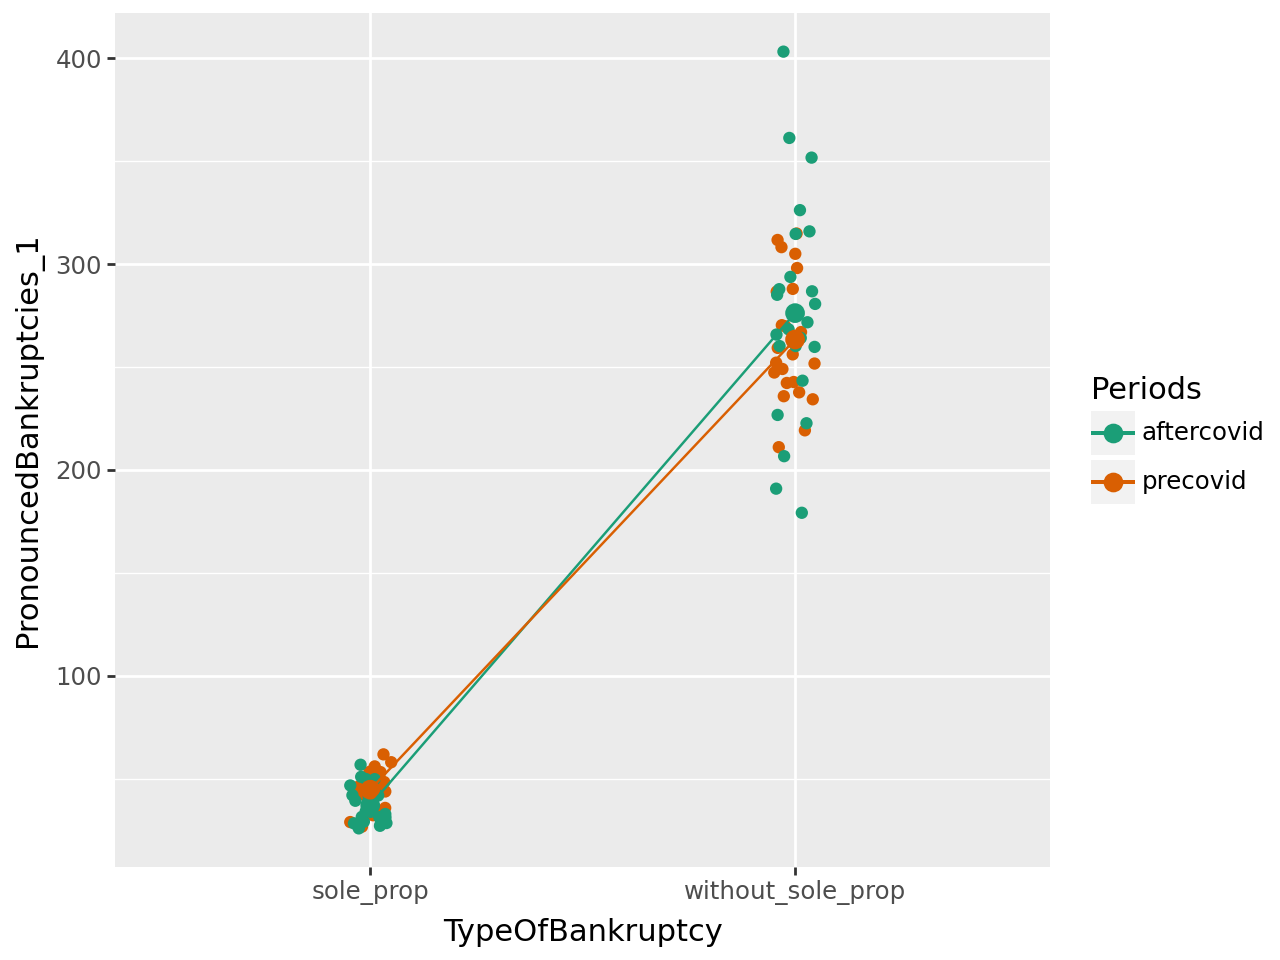

In [103]:
# Visualise the data, timeperiod and type of business vs pronounced bankruptcies via an interaction plot
(ggplot(df_covid,
        aes(x = "TypeOfBankruptcy", y = "PronouncedBankruptcies_1",
            colour = "Periods", group = "Periods")) +
     geom_jitter(width = 0.05) + #  displays the data, with a tiny bit of random noise, to separate the data points a bit for visualisation
     stat_summary(fun_data = "mean_cl_boot",
                  geom = "point", size = 3) +
     stat_summary(fun_data = "mean_cl_boot", # calculates the mean for each group
                  geom = "line") +
     scale_colour_brewer(type = "qual", palette = "Dark2")) # colour palette 

As we can derive from the interaction plot, the two lines intersect slightly, which means that there appears to be an interaction between type of bankruptcy and the time period (before or after COVID-19). We'll test with a two-way ANOVA if this interaction is significant or these two variables individually significantly impact the type of business.

In [105]:
# Create a linear model
model = ols(formula = "PronouncedBankruptcies_1 ~ TypeOfBankruptcy * Periods", data = df_covid)

# and get the fitted parameters of the model
lm_anova = model.fit()

sm.stats.anova_lm(lm_anova, typ = 2)

sum_sq    df            F        PR(>F)
TypeOfBankruptcy          1.258355e+06   1.0  1317.147637  2.602832e-56
Periods                   1.627604e+02   1.0     0.170365  6.807481e-01
TypeOfBankruptcy:Periods  2.511260e+03   1.0     2.628591  1.083773e-01
Residual                  8.789346e+04  92.0          NaN           NaN

The results of the two-way ANOVA indicate that there is no significant interaction between the type of bankruptcy and the timeframe (before or after COVID-19) on the number of declared bankruptcies. Additionally, the timeframe itself does not have a significant effect on the number of bankruptcies. However, the type of bankruptcy does significantly influence the number of bankruptcies ($p<0.01$) . Specifically, as observed in the interaction plot, sole proprietorships tend to experience significantly fewer bankruptcies compared to businesses that are not sole proprietorships.

#
Conclusion

##
The aftermath of the 2008 crisis is strong visible. From 2009 to 2013 bankruptcies in the Netherlands exceeding 7000 cases per year. After 2013, we see a steady decline until 2021 when bankruptcies starting to rise agian due to the Covid-19 crisis.

The interactive choropleth map shows that bankruptcy rates in the Netherlands vary signigicantly by region. Espescially North Holland, South Holland and North Brabant have the highest rates, possible due to the fact that they have the most econoic activities. The Anova analysis shows that the outcome is significant at p<0.05 level.

Business type also impacts bankruptcies where sole proprietorships has lower bankruptcies compared to other businesses. However, we conduct a two-way ANOVA test to compare bankruptcies before Covid-19 (2018-2019) and after (2023), we found no significant effect between business type and timeframe on bankruptcy rates.




### Literature
Schallenberg, L. (2025, March 16). 5 jaar na uitbreken coronacrisis: 'een economisch mirakel'. *NOS*. https://nos.nl/artikel/2559796-5-jaar-na-uitbreken-coronacrisis-een-economisch-mirakel

*pandas.DataFrame.replace*. Retrieved March 21, 2025, from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html

*Plot Multiple lines in Matplotlib*. (2024, Augustus 14). Retrieved March 21, 2025, from  https://www.geeksforgeeks.org/plot-multiple-lines-in-matplotlib/

*pandas.DataFrame.value_counts*. Retrieved March 21, 2025, from https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html

*How to embed image or picture in jupyter notebook, either from a local machine or from a web resource?*. Retrieved March 21, 2025, from https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o

*How to Select Rows from a DataFrame Based on List Values in a Column in Pandas*. (2023, Augustus 19). Retrieved March 22, 2025, from https://saturncloud.io/blog/how-to-select-rows-from-a-dataframe-based-on-list-values-in-a-column-in-pandas/#:~:text=To%20select%20rows%20from%20a%20DataFrame%20based%20on%20a%20list,to%20select%20the%20desired%20rows 

*How to plot a grouped bar plot from two or more dataframes*. Retrieved March 22, 2025, from https://stackoverflow.com/questions/58141058/how-to-plot-a-grouped-bar-plot-from-two-or-more-dataframes 

*Merge, join, concatenate and compare*. Retrieved March 22, 2025, from https://pandas.pydata.org/docs/user_guide/merging.html

*How to test if a string contains one of the substrings in a list, in pandas?*. Retrieved March 23, 2025, from https://stackoverflow.com/questions/26577516/how-to-test-if-a-string-contains-one-of-the-substrings-in-a-list-in-pandas 

*Check For A Substring In A Pandas Dataframe Column*. Retrieved March 23, 2025, from https://www.geeksforgeeks.org/check-for-a-substring-in-a-pandas-dataframe-column/

Van Rongen, M., Castle, M., Jones, E., Nicholls, R., Pavey, H. & Hodgson, V. *Two-way ANOVA*. (2024, October 25). Retrieved March 23, 2025, from https://cambiotraining.github.io/corestats/materials/cs4_practical_two-way-anova.html

*How to Perform a Two-Way ANOVA in Python*. (2022, February 28). https://www.geeksforgeeks.org/how-to-perform-a-two-way-anova-in-python/ 

*Python Pandas DataFrame mask() - Replace Values Based on Condition*. (2024, December 24). Retrieved March 27, 2025, from https://docs.vultr.com/python/third-party/pandas/DataFrame/mask

*Hide all warnings in IPython*. Retrieved March 27, 2025, from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython